# Stock Market Predictions - LSTM Neural Networks

###### Ignacio Antequera Sanchez

# 0. Introduction
---

Hello Everyone! 

Welcome to my Stock Market Predictions Project using ```LSTM Neural Networks```. My name is Ignacio Antequera and in this notebook, I will be sharing with you how we can use a time-series model known as Long Short-Term Memory.

The logic behind this project is to use machine learning models that can look at the history of a sequence of data and correctly predict what the future elements of the sequence are going to be. This is where ```time series modeling``` comes in.

> Disclaimer: This project is solely for learning purposes and does not serve as a financial advisor. Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly.

The objective of this project id to see if we can model the data, so that the predictions we make correlate with the actual behavior of the data. In other words, we don't need the exact stock values of the future, but the stock price movements

### Import Libraries:

In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Downloading the data
---

There are two ways we can access data for this project:

- `Alpha Vnatage Stock API`: This API contains realtime and historical stock market data. This is a reliable source for historical market data that offers a wide range of financial datasets.

    - Since we going to make use of the American Airlines Stock market prices to make your predictions, we set the ticker to `"AAL"`. 
    - We define a `url_string`, which will return a JSON file with all the stock market data for American Airlines within the last 20 years.
    - We define a `file_to_save`, which will be the file to which we save the data. 
    - We will use the `ticker` variable that we defined beforehand to help name this file.
    - Next, we are going to specify a condition: if you haven't already saved data.
    - We will go ahead and grab the data from the URL that we set in `url_string`
    - We'll store the date, low, high, volume, close, open values to a pandas DataFrame df. 
    - We will save it to file_to_save. However, if the data is already there, we'll just load it from the CSV. (This is useful for future runs of the code)

- [Kaggle](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs): This is a huge stock market dataset that contains   Historical daily prices and volumes of all U.S. stocks and ETFs. For the purposes of this demo, I will be using this option. I will be working on HP's stock since it contains a good amount of data that will serve us good for our this demo. However, you may access other demos on this repository where I will be analyzing stocks whose data has been retrieved from Alphavantage. Note that if we select this option, you will need to copy the Stocks folder in the zip file to your project home folder.

In [2]:
data_source = 'kaggle' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '<your API key>'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)
else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


# 2. Data Exploration
---

Now that we have our data properly stored, let's take a quick look at its structure. But first, since we are going to be working on time series modelling, we need to make sure that the data is sorted by date.

In [3]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


# 3. Data Visualization
---

Now, let's take a look at what sort of data we have. We are interested in data with various patterns occurring over time.

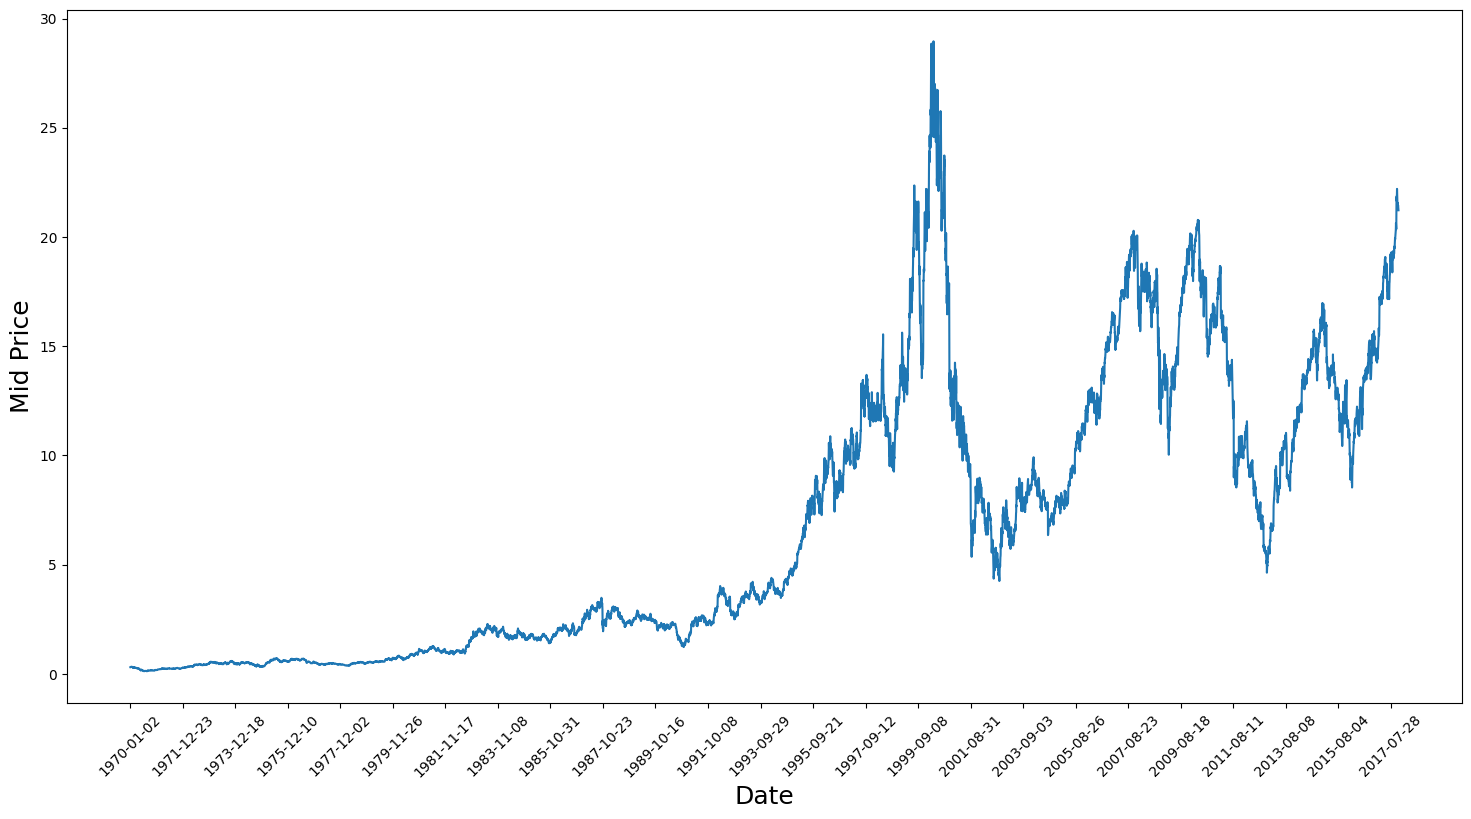

In [4]:
# Set the size of the figure
plt.figure(figsize = (18,9))

# Create the line plot
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)

# Set the x-axis tick marks to be every 500 rows in df
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)

# Set the x-axis and y-axis labels
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)

# Display the plot
plt.show()

This graph provides valuable insights into various aspects. The reason we chose this particular company over others is due to the diverse range of behaviors exhibited by its stock prices over time, making it an excellent candidate for robust learning and providing ample opportunities to evaluate prediction accuracy across different scenarios.

It's worth noting that the stock prices around 2017 exhibit significantly higher values and greater fluctuations compared to those around the 1970s. Therefore, it's essential to ensure consistent value ranges for the data throughout the entire time frame. This normalization process will be addressed during the data normalization phase.

# 4. Splitting Data into Training set and Test set
---

We will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day.

In [5]:
# First calculate the mid prices from the highest and lowest
high_prices = df['High'].values
low_prices = df['Low'].values
mid_prices = (high_prices+low_prices)/2.0

This will allow us to split the training data and test data.

In [6]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

# Verify the shapes of the training and testing sets
print("Training set shape:", train_data.shape)
print("Testing set shape:", test_data.shape)

Training set shape: (11000,)
Testing set shape: (1075,)


It appears that our data has been properly split into training and testing sets. The training set contains 11,000 data points, while the testing set contains 1,075 data points. This aligns with our expectations, as the first 11,000 data points were assigned to the training set, and the remaining data points were assigned to the testing set.

# 5. Normalizing the Data
---

Before proceeding with training our model, it's important to normalize the data to ensure that all features are on a similar scale. Normalization helps in improving the convergence speed and performance of machine learning algorithms, especially those sensitive to feature scales.

Once the data is normalized, we can proceed with training your model using the training set and evaluating its performance on the normalized testing set.

When scaling, we normalize both test and train data with respect to training data because we are not supposed to have access to test data.

In [7]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()

# Reshape the training and testing data to be 2D arrays with a single feature
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

This scaler ensures that the data is scaled to be between 0 and 1

Due to the observation we made earlier, that is, different time periods of data have different value ranges, we will normalize the data by splitting the full series into windows. If we don't do this, the earlier data will be close to 0 and will not add much value to the learning process. In this case we are going to split the data into 4 windows of same size.

In [8]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0, 10000, smoothing_window_size):
    # Fit the scaler to the current window of training data and smooth data
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    
    # Transform and normalize the current window of training data and smooth data
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# Normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape the data back to the shape of [data_size]

In [9]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

We can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

In [10]:
# Initialize variables for exponential moving average (EMA) and smoothing factor (gamma)
EMA = 0.0
gamma = 0.1

# Perform exponential moving average smoothing on the training data
for ti in range(11000):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA

# Concatenate the smoothed training data with the normalized test data for visualization and testing purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

# 6. One-Step Ahead Prediction via Averaging
---
We can better understand the difficulty of this problem by first trying to model this as an average calculation problem. Averaging mechanisms allow us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. 

However, we are going to look at two averaging techniques below:
- `Standard Averaging`
- `Exponential Moving Average`

We will evaluate  the results produced by the two algorithms both qualitatively (visual inspection) and quantitatively (Mean Squared Error).

### Standard Averaging

In this method, you will try to predict the future stock market prices as an average of the previously observed stock market prices within a fixed size window (say previous 100 days). In other words, you say the prediction at `t+1` is the average value of all the stock prices you observed within a window of `t` to `t-N`.

In [11]:
# Define the window size for standard averaging
window_size = 100

# Initialize lists to store predictions, MSE errors, and prediction dates
std_avg_predictions = []
mse_errors = []
std_avg_dates = []

# Calculate the total number of data points in the training set
N = len(train_data)

# Iterate over the indices of the training data, starting from window_size
for pred_idx in range(window_size, N):
    # Calculate the prediction date
    date = df['Date'].iloc[pred_idx]

    # Calculate the standard average prediction
    prediction = np.mean(train_data[pred_idx - window_size:pred_idx])
    std_avg_predictions.append(prediction)

    # Calculate the squared error and append it to the list of MSE errors
    mse_errors.append((prediction - train_data[pred_idx]) ** 2)
    std_avg_dates.append(date)

# Print the MSE error for standard averaging
print('MSE error for standard averaging: %.5f' % (0.5 * np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


It seems like the Mean Squared Error (MSE) for standard averaging in our output is 0.00005. This indicates that the standard averaging method resulted in a relatively low MSE error, which suggests that the predictions are close to the actual values on average.

A low MSE error indicates that the model's predictions are accurate and closely match the actual values. In the context of stock market prediction, a low MSE error indicates that the standard averaging method is performing well in predicting future stock prices based on historical data.

---

Let's Take a look at the averaged results below.

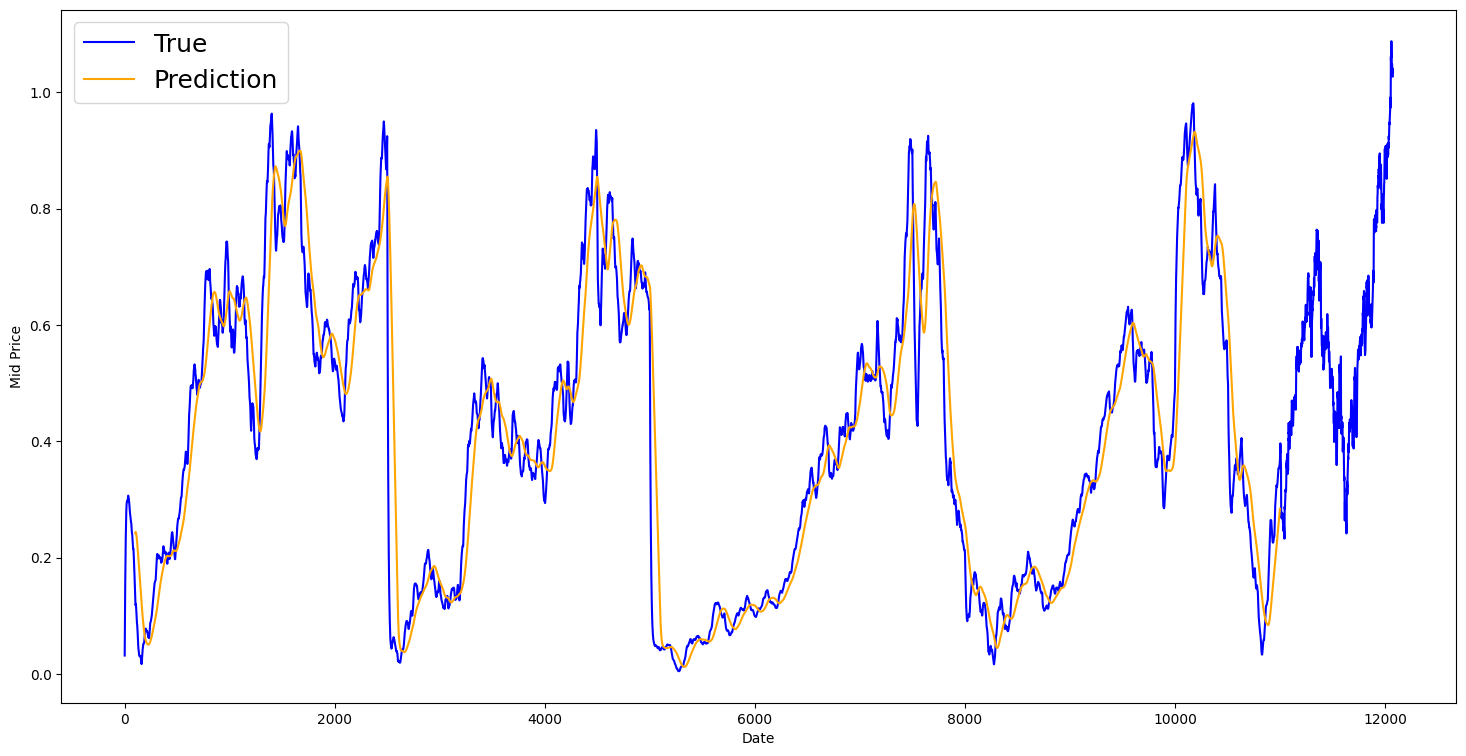

In [12]:
# Visualize the true mid prices and standard averaging predictions
plt.figure(figsize=(18, 9))

# Plot the true mid prices
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='True')

# Plot the standard averaging predictions
plt.plot(range(window_size, N), std_avg_predictions, color='orange', label='Prediction')

# Set x-axis label
plt.xlabel('Date')

# Set y-axis label
plt.ylabel('Mid Price')

# Add legend to the plot
plt.legend(fontsize=18)

# Display the plot
plt.show()

The model appears to perform reasonably well for very short-term predictions (one day ahead). This is sensible since stock prices typically do not undergo drastic changes overnight.

### Exponential Moving Average

In the exponential moving average method, we make our predictions such that:

x_{t+1} = EMA_{t} = \gamma \times EMA_{t-1} + (1-\gamma) x_t

where \( EMA_0 = 0 \) and \( EMA \) is the exponential moving average value maintained over time.

The above equation basically calculates the exponential moving average from $t+1$ time step and uses that as the one step ahead prediction. $\gamma$ decides what the contribution of the most recent prediction is to the EMA. For example, a $\gamma=0.1$ gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. See how good this looks when used to predict one-step ahead below.

In [13]:
# Set the window size for the exponential moving average
window_size = 100

# Calculate the total number of data points in the training set
N = len(train_data)

# Initialize lists to store predictions, dates, and MSE errors
run_avg_predictions = []
run_avg_x = []
mse_errors = []

# Initialize the running mean using the first window of data
running_mean = np.mean(train_data[:window_size])
run_avg_predictions.append(running_mean)

# Define the decay factor for exponential decay
decay = 0.5

# Iterate over the indices of the training data
for pred_idx in range(1, N):
    # Calculate the running mean using exponential decay
    running_mean = running_mean * decay + (1.0 - decay) * train_data[pred_idx - 1]
    run_avg_predictions.append(running_mean)
    
    # Calculate the squared error and append it to the list of MSE errors
    squared_error = (running_mean - train_data[pred_idx]) ** 2
    mse_errors.append(squared_error)
    
    # Append date if available
    run_avg_x.append(date)  # Make sure 'date' is defined within the loop

# Calculate the MSE error for EMA averaging
mse_error_ema = 0.5 * np.mean(mse_errors)
print('MSE error for EMA averaging: %.5f' % mse_error_ema)

MSE error for EMA averaging: 0.00003


This low MSE value suggests that the EMA method is performing well in predicting future stock prices one step ahead, based on the given historical data. A lower MSE indicates that the predictions are close to the actual values, demonstrating the effectiveness of the EMA averaging technique in this context.

Now, let's visualize the results of the EMA predictions along with the true values.

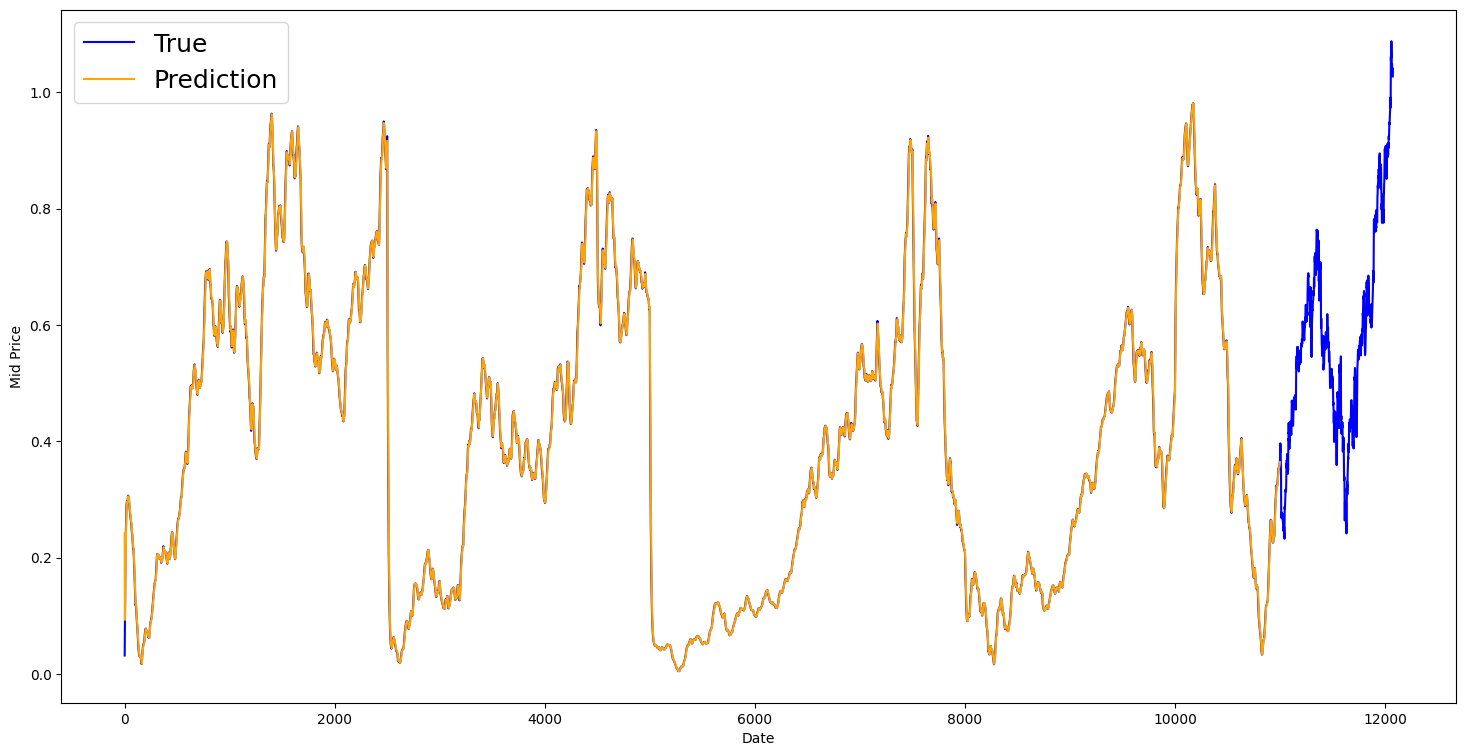

In [14]:
# Visualize the true values and predictions using Exponential Moving Average (EMA)
plt.figure(figsize=(18, 9))
plt.plot(range(df.shape[0]), all_mid_data, color='b', label='True')  # Plot true values
plt.plot(range(0, N), run_avg_predictions, color='orange', label='Prediction')  # Plot EMA predictions

plt.xlabel('Date')  # Set x-axis label
plt.ylabel('Mid Price')  # Set y-axis label
plt.legend(fontsize=18)  # Add legend with font size
plt.show()  # Display the plot

Exponential Moving Average (EMA) may seem to perform well in predicting the next day's stock market value, as evidenced by its low Mean Squared Error (MSE) and close alignment with the true distribution. However, in practical terms, knowing just the next day's value isn't particularly useful. What's more valuable is understanding whether stock prices will rise or fall over the next 30 days. Attempting to predict larger windows of time reveals the limitations of EMA.

For instance, consider the scenario where $x_t=0.4$, $EMA=0.5$, and $\gamma = 0.5$:
- Using the equation $X_{t+1} = EMA_t = \gamma \times EMA_{t-1} + (1 - \gamma)X_t$, we find $x_{t+1} = 0.5 \times 0.5 + (1-0.5) \times 0.4 = 0.45$. Consequently, $X_{t+1} = EMA_t = 0.45$.

Applying the same logic for $X_{t+2}$: 
- we get $X_{t+2} = \gamma \times EMA_t + (1-\gamma)X_{t+1}$.
- Substituting the values, $X_{t+2} = \gamma \times EMA_t + (1-\gamma) EMA_t = EMA_t = 0.45$. 

This means that regardless of how many steps into the future we predict, we'll always get the same answer.

To address this limitation and obtain more meaningful predictions, we can explore momentum-based algorithms. These algorithms assess whether recent values have been increasing or decreasing, rather than focusing on exact values. For example, if prices have been declining in recent days, these algorithms might predict a lower price for the next day, which aligns with intuitive expectations. However, for a more sophisticated approach, we'll utilize a Long Short-Term Memory (LSTM) model.

LSTM models have gained popularity in time series prediction due to their ability to effectively model temporal data. We'll investigate whether there are discernible patterns in the data that can be leveraged for more accurate predictions.

# 7. Making Stock Movement Predictions Far into the Future
---
Long Short-Term Memory models are extremely powerful time-series models. They can predict an arbitrary number of steps into the future. TensorFlow provides a nice sub API (called RNN API) for implementing time series models. We will be using that for our implementations.

### Data Generator

Initially, we'll create a data generator to facilitate model training. This generator will feature a function named `.unroll_batches(...)` responsible for generating a sequence of batches of input data, each with a size of `[batch_size, 1]`. These batches will be extracted sequentially, ensuring that each batch of input data corresponds to a corresponding output batch of data.

### Data Augmentation

Also, in order to make our model robus, we will not make the output for $x\_t$ always $x\_{t+1}$. Instead, we will randomly sample an output from the set $x\_{t+1},x\_{t+2},\ldots,x_{t+N}$ where $N$ is a small window size.

Here we are making the following assumption:

- $x\_{t+1},x\_{t+2},\ldots,x_{t+N}$ will not be very far from each other

This is a reasonable assumption for stock movement predictions.

In [15]:
class DataGeneratorSeq(object):

    def __init__(self, prices, batch_size, num_unroll):
        """
        Initialize the DataGeneratorSeq object.

        Args:
            prices (array-like): Input data (prices).
            batch_size (int): Number of sequences in each batch.
            num_unroll (int): Number of time steps to unroll the RNN.

        """
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        # Calculate the number of segments
        self._segments = self._prices_length // self._batch_size
        # Initialize cursor for each batch
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):
        """
        Generate the next batch of data and corresponding labels.

        Returns:
            batch_data (ndarray): Batch of input data.
            batch_labels (ndarray): Batch of corresponding labels.

        """
        batch_data = np.zeros((self._batch_size), dtype=np.float32)
        batch_labels = np.zeros((self._batch_size), dtype=np.float32)

        for b in range(self._batch_size):
            # Check if the cursor exceeds the price length
            if self._cursor[b] + 1 >= self._prices_length:
                # If so, reset the cursor to a random position within the segment
                self._cursor[b] = np.random.randint(0, (b + 1) * self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            # Randomly sample label from the next few steps
            batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(0, 5)]

            # Move the cursor forward
            self._cursor[b] = (self._cursor[b] + 1) % self._prices_length

        return batch_data, batch_labels

    def unroll_batches(self):
        """
        Unroll multiple batches of data and labels.

        Returns:
            unroll_data (list of ndarray): List of unrolled input data.
            unroll_labels (list of ndarray): List of unrolled corresponding labels.

        """
        unroll_data, unroll_labels = [], []
        for _ in range(self._num_unroll):
            data, labels = self.next_batch()
            unroll_data.append(data)
            unroll_labels.append(labels)
        return unroll_data, unroll_labels

    def reset_indices(self):
        """
        Reset the cursor positions for each batch randomly within the allowable range.

        """
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0, min((b + 1) * self._segments, self._prices_length - 1))


dg = DataGeneratorSeq(train_data, 5, 5)
u_data, u_labels = dg.unroll_batches()

for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
    print('\n\nUnrolled index %d' % ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ', dat)
    print('\n\tOutput:', lbl)



Unrolled index 0
	Inputs:  [0.03143791 0.6904868  0.82829314 0.32585657 0.11600105]

	Output: [0.132895   0.68685144 0.82829314 0.33078218 0.11600105]


Unrolled index 1
	Inputs:  [0.06067836 0.6890754  0.8325337  0.32857886 0.11785509]

	Output: [0.15261841 0.6836884  0.8329321  0.33421066 0.12106793]


Unrolled index 2
	Inputs:  [0.08698314 0.68685144 0.8329321  0.33078218 0.11946969]

	Output: [0.17132245 0.68685144 0.833369   0.33355275 0.12158521]


Unrolled index 3
	Inputs:  [0.11098009 0.6858036  0.83294916 0.33219692 0.12106793]

	Output: [0.132895   0.6820074  0.833141   0.33219692 0.12288672]


Unrolled index 4
	Inputs:  [0.132895   0.6848606  0.833369   0.33355275 0.12158521]

	Output: [0.20387813 0.6836884  0.833141   0.33355275 0.12288672]


The data augmentation technique used in this code randomly samples labels from the next few steps within a small window size (5 in this case). This randomness ensures that the model sees a variety of label samples during training, which can help improve its robustness and generalization capability. 

Therefore, getting different outputs each time we run the code is expected behavior and does not indicate any issues with the implementation. It simply reflects the stochastic nature of the data augmentation process. As long as the overall training process is converging and producing satisfactory results, this variability is acceptable.

### Defining Hyperparameters

In this section, we will set and define the hyperparameters that govern the behavior and architecture of our Long Short-Term Memory (LSTM) model. These hyperparameters play a crucial role in shaping how the model learns from the input data and makes predictions. We will carefully select values for each hyperparameter based on considerations such as the nature of the problem, the characteristics of the data, and computational constraints.

The hyperparameters we will define include:

1. `Input Dimensionality` (D): This parameter specifies the dimensionality of the input data. Since we are working with time-series data of stock prices, where each data point represents a single price value, the input dimensionality (D) will be set to 1.

2. `Number of Unrollings` (num_unrollings): This hyperparameter is related to the concept of backpropagation through time (BPTT) in recurrent neural networks (RNNs). It determines the number of consecutive time steps considered for a single optimization step during training. By unrolling the network for a certain number of time steps, the model can capture temporal dependencies over longer sequences of input data.

3. `Batch Size`: Batch size refers to the number of data samples processed in parallel during each training iteration. It affects the efficiency of training and the stability of the optimization process. Larger batch sizes can lead to faster convergence but may require more memory and computational resources.

4. `Number of Nodes` (num_nodes): This parameter defines the number of hidden units (neurons) in each LSTM cell. The LSTM model consists of multiple layers, and num_nodes specifies the size of each layer. Increasing the number of nodes can enhance the model's capacity to learn complex patterns in the data but may also increase the computational cost.

By carefully setting these hyperparameters, we aim to configure our LSTM model in a way that balances model complexity, training efficiency, and predictive performance. Adjusting these parameters may involve experimentation and tuning to achieve the best results for our specific forecasting task of predicting stock price movements.

In [16]:
# Dimensionality of the input data. Since the data is 1-D (stock prices), this would be 1
D = 1

# Number of time steps to look into the future for each prediction
num_unrollings = 50

# Number of samples (data points) in each training batch
batch_size = 500

# Number of hidden nodes (neurons) in each layer of the deep LSTM stack
num_nodes = [200, 200, 150]  # Define the number of hidden nodes for each layer of the LSTM stack
n_layers = len(num_nodes)  # Total number of layers in the LSTM stack

# Dropout amount to prevent overfitting (if needed)
dropout = 0.2

# Reset the TensorFlow default graph to ensure clean execution
tf.keras.backend.clear_session()

### Defining Inputs and Outputs

Now, we will define placeholders for training inputs and labels. This is very straightforward as we have a list of input placeholders, where each placeholder contains a single batch of data.

The list has `num_unrollings` placeholders, that will be used at once for a single optimization step.

In [17]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Input data.
train_inputs, train_outputs = [], []

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size, D], name='train_inputs_%d' % ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size, 1], name='train_outputs_%d' % ui))

### Defining Parameters of the LSTM and Regression layer

In this section, we'll be defining the parameters for our Long Short-Term Memory (LSTM) model and the regression layer. The LSTM model will consist of three layers, allowing us to capture complex temporal patterns in the data effectively. Each LSTM layer will contain a certain number of neurons, referred to as the hidden nodes, which determine the model's capacity to learn and represent the data.

Additionally, we'll incorporate a linear regression layer, which serves as the output layer of our model. This layer, represented by weight (w) and bias (b) parameters, will take the output of the last LSTM cell and produce predictions for the next time step.

To implement the three LSTM layers, we'll utilize TensorFlow's `MultiRNNCell`, a convenient way to stack multiple LSTM cells. This enables our model to capture hierarchical representations of the input data, learning both short-term dependencies within each layer and long-term dependencies across layers.

Furthermore, we'll incorporate dropout regularization within the LSTM cells. Dropout helps prevent overfitting by randomly dropping a fraction of neuron units during training, forcing the model to learn more robust and generalizable representations of the data.

By defining these parameters and architectural components, we aim to build a powerful LSTM-based model capable of effectively capturing temporal dependencies in the data and making accurate predictions for future time steps.

In [18]:
# Define LSTM layers for each layer
lstm_cells = [
    LSTM(units=num_nodes[li],  # Number of neurons in the current layer
         return_sequences=True if li < n_layers - 1 else False,  # Return sequences for all but the last layer
         kernel_initializer=tf.keras.initializers.GlorotUniform()  # Initialize weights
        )
    for li in range(n_layers)  # Iterate over the number of layers
]

# Apply dropout regularization to LSTM layers
drop_lstm_cells = [
    Dropout(rate=dropout)  # Apply dropout with specified rate
    for _ in range(n_layers)  # Iterate over the number of layers
]

# Define the linear regression layer weights and biases
w = tf.Variable(tf.keras.initializers.GlorotUniform()((num_nodes[-1], 1)), name='w')  # Initialize weights
b = tf.Variable(tf.random.uniform((1,), -0.1, 0.1), name='b')  # Initialize biases

### Calculating LSTM output and Feeding it to the regression layer

In this section, we are performing several key steps to calculate the LSTM output and feed it to the regression layer in order to obtain the final prediction. Here's a comprehensive explanation of each step:

1. **Initialization of LSTM Cell State and Hidden State Variables (c and h):**
   - We initialize TensorFlow variables `c` and `h` to hold the cell state and the hidden state of the Long Short-Term Memory (LSTM) cell. These variables will be updated during the computation of LSTM outputs.

2. **Transformation of Input Data Shape:**
   - Before feeding the input data to the LSTM model, we need to transform it to a specific shape. The input data (`train_inputs`) is initially in the form of a list of input tensors. We reshape this list to have a shape of `[num_unrollings, batch_size, D]`, where:
     - `num_unrollings` represents the number of time steps we are unrolling the LSTM model for.
     - `batch_size` is the number of sequences (or samples) in each training batch.
     - `D` is the dimensionality of the input data, which in this case is 1 for stock prices (1-D data).

3. **Calculation of LSTM Outputs:**
   - We use the `tf.nn.dynamic_rnn` function to calculate the LSTM outputs. This function takes the transformed input data and the LSTM cell as input and computes the outputs of the LSTM model for each time step. The outputs are of shape `[num_unrollings, batch_size, num_nodes[-1]]`, where `num_nodes[-1]` is the number of hidden nodes in the last layer of the LSTM stack.

4. **Splitting the Output:**
   - After obtaining the LSTM outputs, we split them back into a list of `num_unrollings` tensors. Each tensor in this list represents the output of the LSTM model at a specific time step.

5. **Calculation of Loss:**
   - Finally, we compute the loss between the predictions generated by the LSTM model and the true stock prices. This loss quantifies the discrepancy between the predicted values and the actual values, and it serves as the objective function to be minimized during the training process.

Overall, this section prepares the input data, computes the LSTM outputs, and calculates the loss, which are essential steps in training an LSTM model for time series prediction tasks such as stock price prediction.

In [19]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

AttributeError: module 'tensorflow' has no attribute 'contrib'

### Loss Calculation and Optimizer

